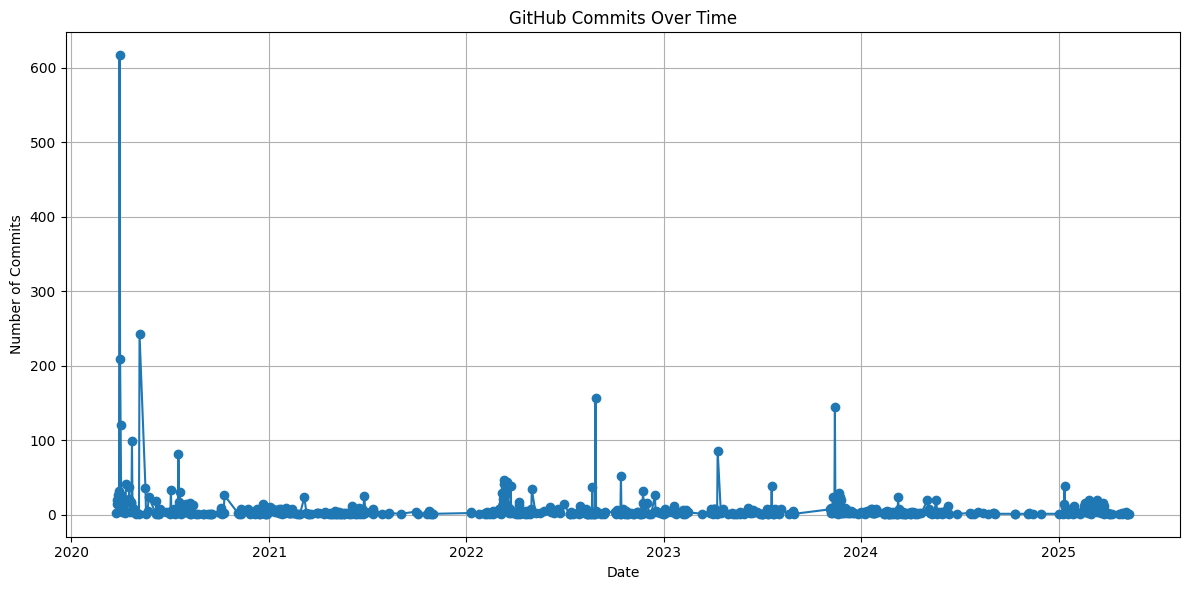

In [48]:
import os
import requests
from datetime import datetime
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from dotenv import load_dotenv

# Load environment variables
load_dotenv()
TOKEN = os.getenv('GRAPH_GITHUB_TOKEN')
OWNER = os.getenv('GRAPH_REPO_OWNER')
REPO = os.getenv('GRAPH_REPO_NAME')

# GitHub API headers
headers = {
    "Authorization": f"token {TOKEN}",
    "Accept": "application/vnd.github.v3+json"
}

# Get commits from the GitHub API
def get_commits(owner, repo):
    commits = []
    page = 1
    while True:
        url = f"https://api.github.com/repos/{owner}/{repo}/commits?page={page}&per_page=100"
        response = requests.get(url, headers=headers)
        data = response.json()
        if not data or response.status_code != 200:
            break
        commits.extend(data)
        page += 1
    return commits

# Extract commit dates (in YYYY-MM-DD)
def extract_dates(commits):
    dates = [
        commit['commit']['author']['date'][:10]
        for commit in commits
    ]
    return dates

# Count commits per date
def count_commits_by_date(dates):
    counter = Counter(dates)
    return sorted(counter.items())

# Plot the graph
def plot_commit_history(commit_data):
    dates, counts = zip(*commit_data)
    dates = [datetime.strptime(date, "%Y-%m-%d") for date in dates]
    plt.figure(figsize=(12, 6))
    plt.plot(dates, counts, marker='o')
    plt.title("GitHub Commits Over Time")
    plt.xlabel("Date")
    plt.ylabel("Number of Commits")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    commits = get_commits(OWNER, REPO)
    dates = extract_dates(commits)
    commit_data = count_commits_by_date(dates)
    plot_commit_history(commit_data)


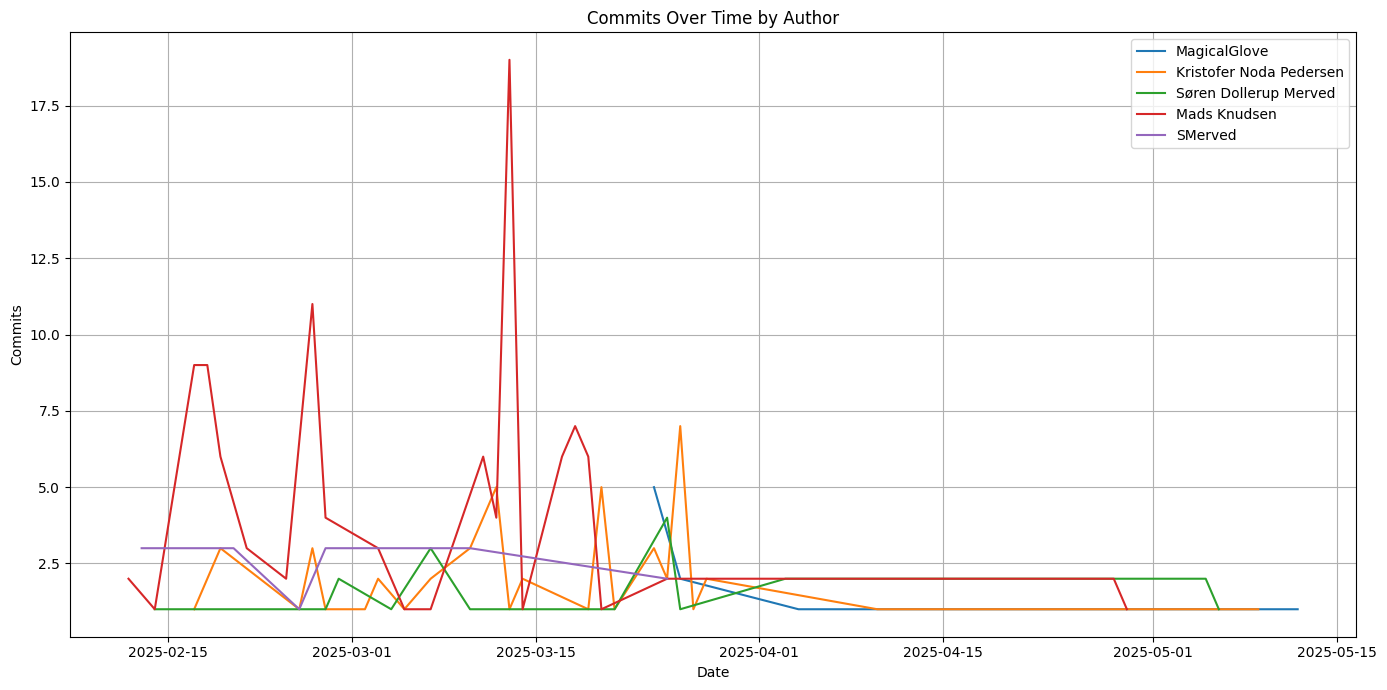

In [49]:
ALLOWED_AUTHORS =["Mads Knudsen", "Mfknudsen", "SMerved", "Søren Dollerup Merved", "KurisuDaNoda", "Kristofer Noda Pedersen", "MagicalGlove"]
# Get commits from GitHub
def get_commits(owner, repo):
    commits = []
    page = 1
    while True:
        url = f"https://api.github.com/repos/{owner}/{repo}/commits?page={page}&per_page=100"
        response = requests.get(url, headers=headers)
        data = response.json()
        if not data or response.status_code != 200:
            break
        commits.extend(data)
        page += 1
    return commits

# Extract (author, date) tuples
def extract_author_dates(commits):
    author_dates = []
    for commit in commits:
        try:
            author = commit['commit']['author']['name']
            if author in ALLOWED_AUTHORS:
                date = commit['commit']['author']['date'][:10]  # YYYY-MM-DD
                author_dates.append((author, date))
        except KeyError:
            continue
    return author_dates

# Count commits per author per date
def count_commits_by_author_date(author_dates):
    author_date_counts = defaultdict(Counter)
    for author, date in author_dates:
        author_date_counts[author][date] += 1
    return author_date_counts

# Plot commits over time per author
def plot_commits(author_date_counts):
    plt.figure(figsize=(14, 7))

    for author, date_counts in author_date_counts.items():
        dates = sorted(date_counts)
        values = [date_counts[date] for date in dates]
        date_objs = [datetime.strptime(date, "%Y-%m-%d") for date in dates]
        plt.plot(date_objs, values, label=author)

    plt.title("Commits Over Time by Author")
    plt.xlabel("Date")
    plt.ylabel("Commits")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    commits = get_commits(OWNER, REPO)
    author_dates = extract_author_dates(commits)
    author_date_counts = count_commits_by_author_date(author_dates)
    plot_commits(author_date_counts)

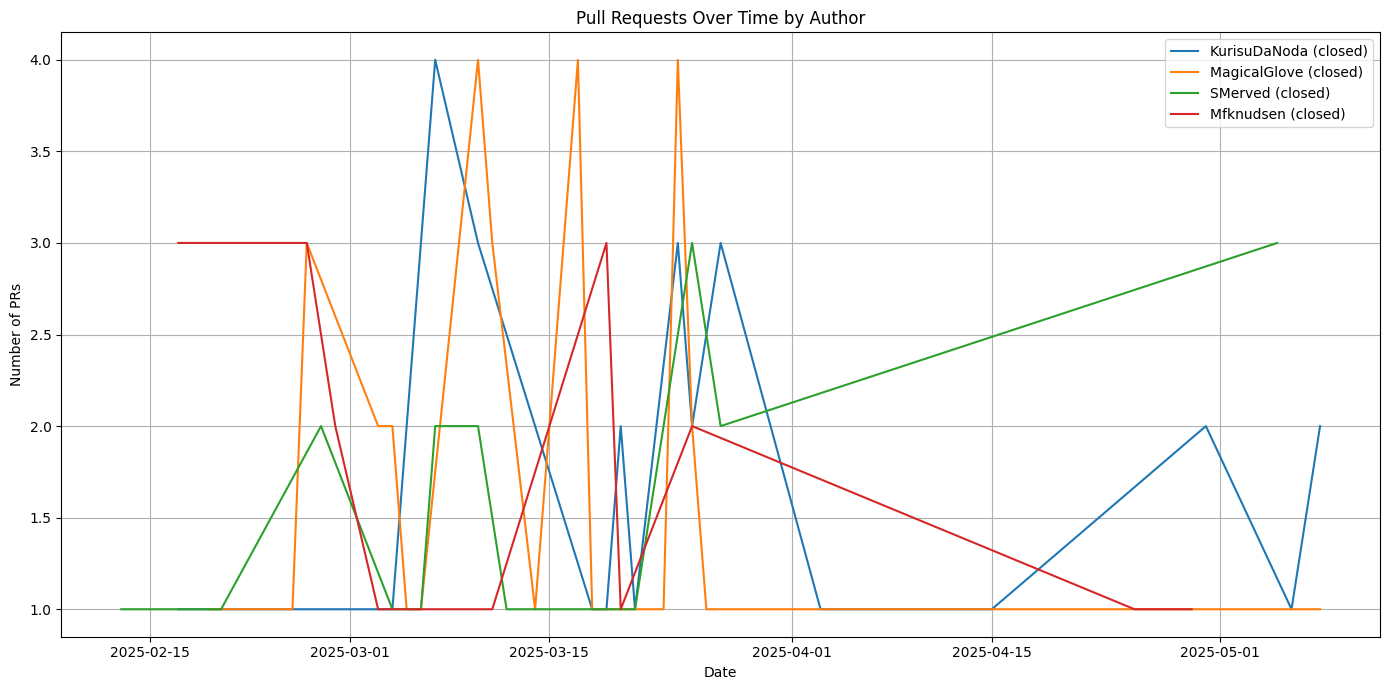

In [50]:
ALLOWED_AUTHORS =["Mads Knudsen", "Mfknudsen", "SMerved", "Søren Dollerup Merved", "KurisuDaNoda", "Kristofer Noda Pedersen", "MagicalGlove"]

headers = {
    "Authorization": f"token {TOKEN}",
    "Accept": "application/vnd.github.v3+json"
}

# Get pull requests (open + closed)
def get_pull_requests(owner, repo, max_pages=10):
    prs = []
    page = 1
    while page <= max_pages:
        url = f"https://api.github.com/repos/{owner}/{repo}/pulls?state=all"
        params = {
            "per_page": 100,
            "page": page
        }
        response = requests.get(url, headers=headers, params=params)
        if response.status_code != 200:
            break
        data = response.json()
        if not data:
            break
        prs.extend(data)
        page += 1
    return prs

# Extract (author, date, state) for PRs
def extract_author_pr_dates(prs):
    author_dates = []
    for pr in prs:
        if pr.get("user") and pr["user"]["login"]:
            author = pr["user"]["login"]
            if author in ALLOWED_AUTHORS:
                date_str = pr["created_at"][:10]  # YYYY-MM-DD
                state = pr["state"]  # 'open' or 'closed'
                author_dates.append((author, date_str, state))
    return author_dates

# Count PRs per author per date (optionally grouped by state)
def count_prs_by_author_date(author_dates):
    author_date_counts = defaultdict(lambda: Counter())
    for author, date, state in author_dates:
        key = f"{author} ({state})"
        author_date_counts[key][date] += 1
    return author_date_counts

# Plot PRs over time per author
def plot_prs(author_date_counts):
    plt.figure(figsize=(14, 7))
    for author_state, date_counts in author_date_counts.items():
        dates = sorted(date_counts)
        counts = [date_counts[date] for date in dates]
        date_objs = [datetime.strptime(date, "%Y-%m-%d") for date in dates]
        plt.plot(date_objs, counts, label=author_state)

    plt.title("Pull Requests Over Time by Author")
    plt.xlabel("Date")
    plt.ylabel("Number of PRs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    prs = get_pull_requests(OWNER, REPO)
    author_dates = extract_author_pr_dates(prs)
    author_date_counts = count_prs_by_author_date(author_dates)
    plot_prs(author_date_counts)

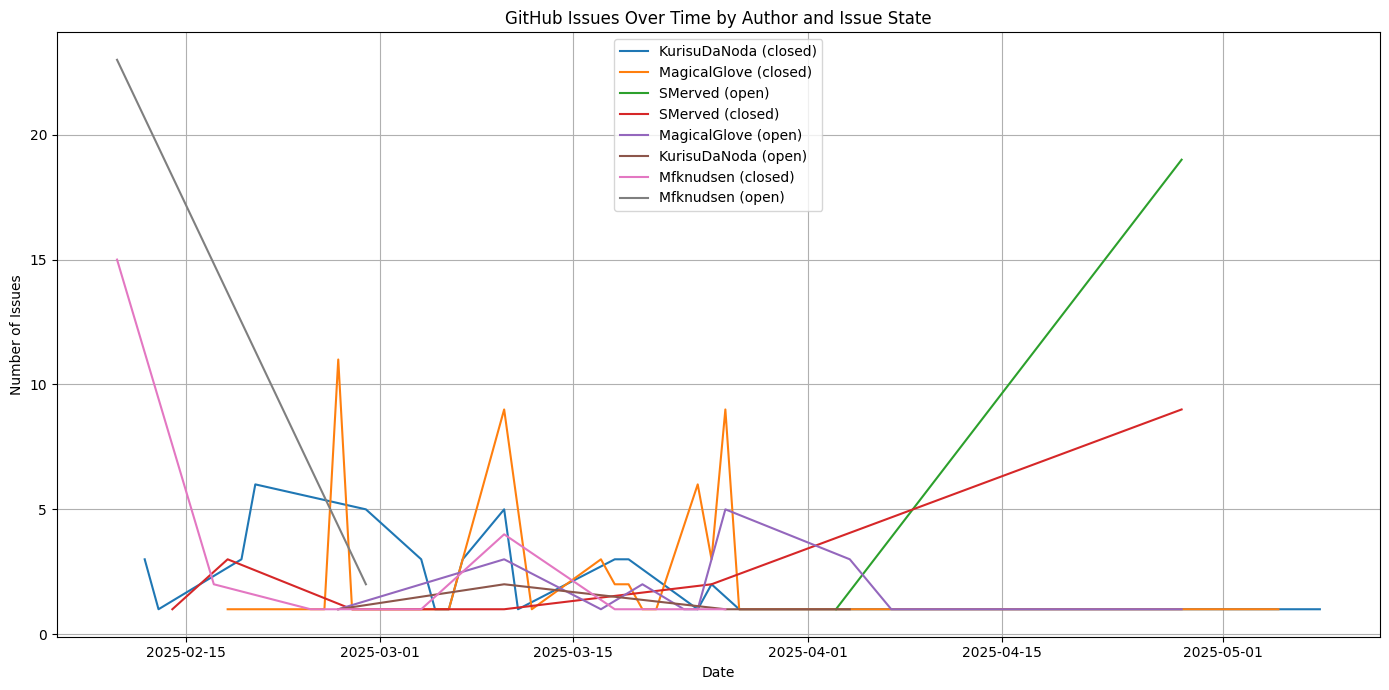

In [51]:
# Get issues (excluding PRs)
def get_issues(owner, repo, max_pages=10):
    issues = []
    page = 1
    while page <= max_pages:
        url = f"https://api.github.com/repos/{owner}/{repo}/issues"
        params = {
            "state": "all",
            "per_page": 100,
            "page": page
        }
        response = requests.get(url, headers=headers, params=params)
        if response.status_code != 200:
            break
        data = response.json()
        if not data:
            break
        for issue in data:
            # Filter out pull requests (they show up as issues too)
            if 'pull_request' not in issue:
                issues.append(issue)
        page += 1
    return issues

# Extract (author, date, state) from issues
def extract_author_issue_dates(issues):
    author_dates = []
    for issue in issues:
        user = issue.get("user", {})
        author = user.get("login", "")
        if author in ALLOWED_AUTHORS:
            date = issue["created_at"][:10]  # YYYY-MM-DD
            state = issue["state"]
            author_dates.append((author, date, state))
    return author_dates

# Count issues per author per date
def count_issues_by_author_date(author_dates):
    author_date_counts = defaultdict(Counter)
    for author, date, state in author_dates:
        key = f"{author} ({state})"
        author_date_counts[key][date] += 1
    return author_date_counts

# Plot issues over time
def plot_issues(author_date_counts):
    plt.figure(figsize=(14, 7))
    for author_state, date_counts in author_date_counts.items():
        dates = sorted(date_counts)
        counts = [date_counts[date] for date in dates]
        date_objs = [datetime.strptime(date, "%Y-%m-%d") for date in dates]
        plt.plot(date_objs, counts, label=author_state)

    plt.title("GitHub Issues Over Time by Author and Issue State")
    plt.xlabel("Date")
    plt.ylabel("Number of Issues")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    issues = get_issues(OWNER, REPO)
    author_dates = extract_author_issue_dates(issues)
    author_date_counts = count_issues_by_author_date(author_dates)
    plot_issues(author_date_counts)

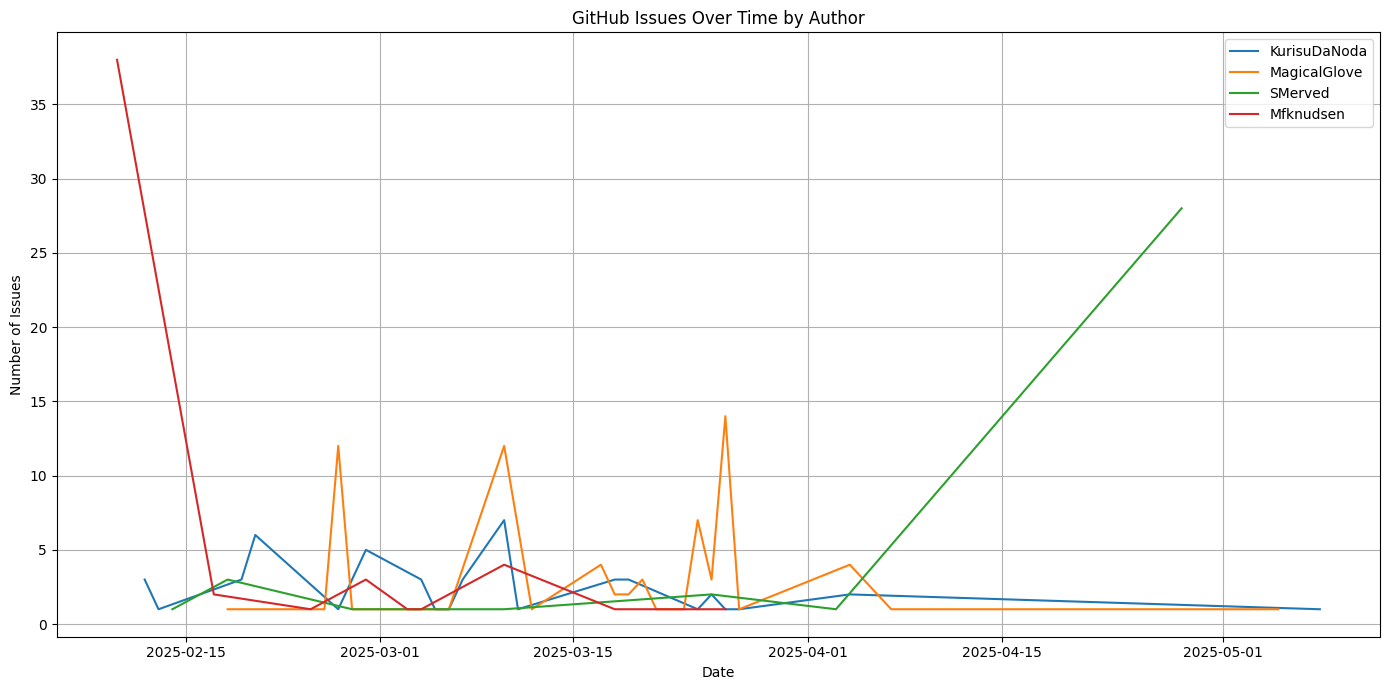

In [52]:
# Get issues (excluding PRs)
def get_issues(owner, repo, max_pages=10):
    issues = []
    page = 1
    while page <= max_pages:
        url = f"https://api.github.com/repos/{owner}/{repo}/issues"
        params = {
            "state": "all",
            "per_page": 100,
            "page": page
        }
        response = requests.get(url, headers=headers, params=params)
        if response.status_code != 200:
            break
        data = response.json()
        if not data:
            break
        for issue in data:
            # Filter out pull requests (they show up as issues too)
            if 'pull_request' not in issue:
                issues.append(issue)
        page += 1
    return issues

# Extract (author, date, state) from issues
def extract_author_issue_dates(issues):
    author_dates = []
    for issue in issues:
        user = issue.get("user", {})
        author = user.get("login", "")
        if author in ALLOWED_AUTHORS:
            date = issue["created_at"][:10]  # YYYY-MM-DD
            state = issue["state"]
            author_dates.append((author, date, state))
    return author_dates

# Count issues per author per date
def count_issues_by_author_date(author_dates):
    author_date_counts = defaultdict(Counter)
    for author, date, state in author_dates:
        author_date_counts[author][date] += 1  # Just use author
    return author_date_counts

# Plot issues over time
def plot_issues(author_date_counts):
    plt.figure(figsize=(14, 7))
    for author_state, date_counts in author_date_counts.items():
        dates = sorted(date_counts)
        counts = [date_counts[date] for date in dates]
        date_objs = [datetime.strptime(date, "%Y-%m-%d") for date in dates]
        plt.plot(date_objs, counts, label=author_state)

    plt.title("GitHub Issues Over Time by Author")
    plt.xlabel("Date")
    plt.ylabel("Number of Issues")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    issues = get_issues(OWNER, REPO)
    author_dates = extract_author_issue_dates(issues)
    author_date_counts = count_issues_by_author_date(author_dates)
    plot_issues(author_date_counts)

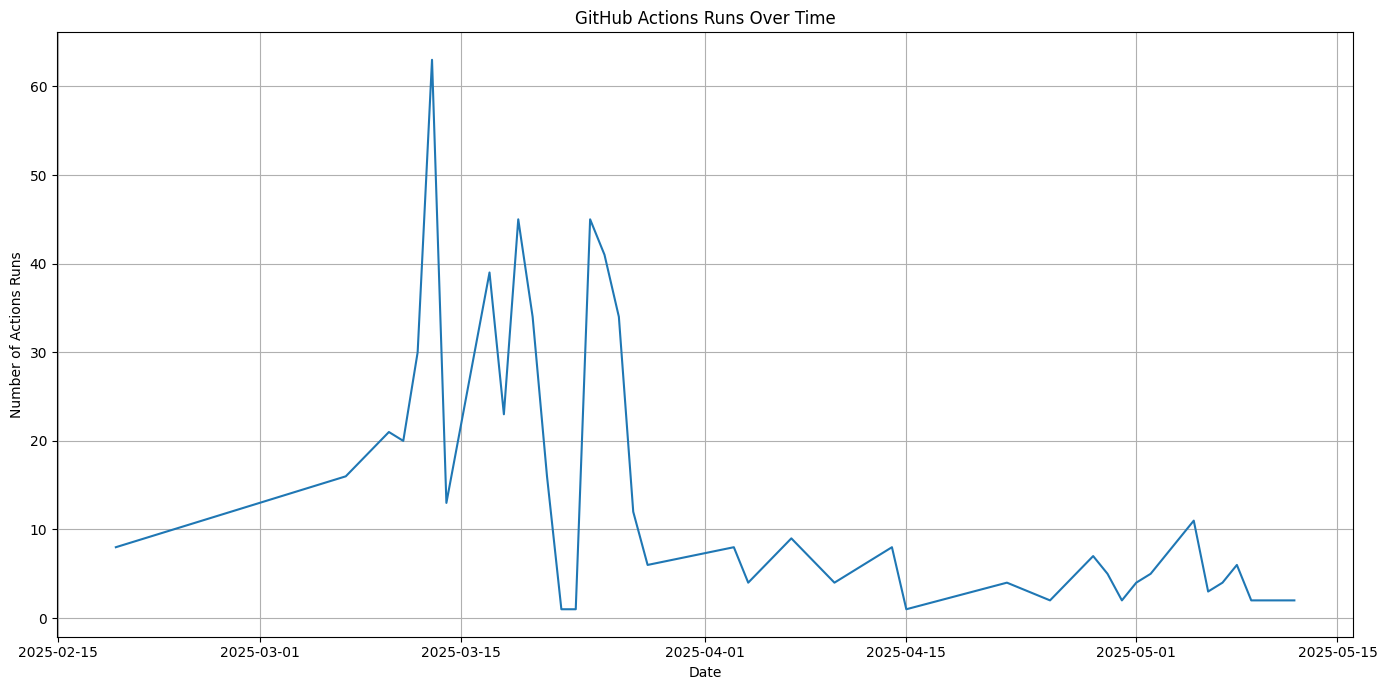

In [53]:
# Get GitHub Actions runs
def get_actions_runs(owner, repo, max_pages=10):
    runs = []
    page = 1
    while page <= max_pages:
        url = f"https://api.github.com/repos/{owner}/{repo}/actions/runs"
        params = {
            "per_page": 100,
            "page": page
        }
        response = requests.get(url, headers=headers, params=params)
        if response.status_code != 200:
            break
        data = response.json()
        if not data.get('workflow_runs'):
            break
        runs.extend(data['workflow_runs'])
        page += 1
    return runs

# Extract (date) from the workflow runs (without filtering by author)
def extract_run_dates(runs):
    run_dates = []
    for run in runs:
        date = run['created_at'][:10]  # YYYY-MM-DD
        run_dates.append(date)
    return run_dates

# Count actions runs per date (no author grouping)
def count_runs_by_date(run_dates):
    date_counts = Counter(run_dates)
    return date_counts

# Plot actions runs over time
def plot_actions_runs(date_counts):
    plt.figure(figsize=(14, 7))
    dates = sorted(date_counts)
    counts = [date_counts[date] for date in dates]
    date_objs = [datetime.strptime(date, "%Y-%m-%d") for date in dates]
    plt.plot(date_objs, counts, label="Total Actions Runs")

    plt.title("GitHub Actions Runs Over Time")
    plt.xlabel("Date")
    plt.ylabel("Number of Actions Runs")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    runs = get_actions_runs(OWNER, REPO)
    run_dates = extract_run_dates(runs)
    date_counts = count_runs_by_date(run_dates)
    plot_actions_runs(date_counts)


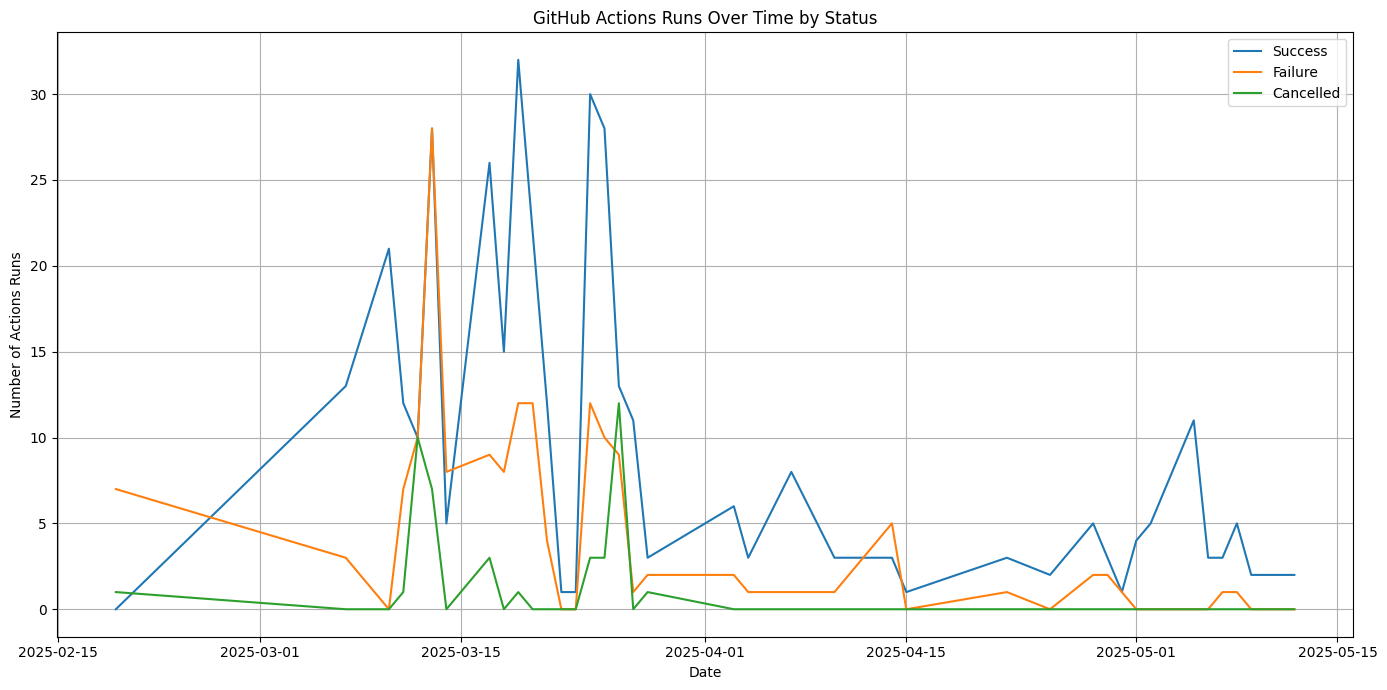

In [54]:
# Get GitHub Actions runs
def get_actions_runs(owner, repo, max_pages=10):
    runs = []
    page = 1
    while page <= max_pages:
        url = f"https://api.github.com/repos/{owner}/{repo}/actions/runs"
        params = {
            "per_page": 100,
            "page": page
        }
        response = requests.get(url, headers=headers, params=params)
        if response.status_code != 200:
            break
        data = response.json()
        if not data.get('workflow_runs'):
            break
        runs.extend(data['workflow_runs'])
        page += 1
    return runs

# Extract (date, result status) from the workflow runs
def extract_run_dates_and_status(runs):
    run_dates_status = []
    for run in runs:
        date = run['created_at'][:10]  # YYYY-MM-DD
        status = run['conclusion']  # Status: 'success', 'failure', 'neutral', etc.
        run_dates_status.append((date, status))
    return run_dates_status

# Count actions runs per date and status
def count_runs_by_date_and_status(run_dates_status):
    date_status_counts = defaultdict(lambda: Counter())
    for date, status in run_dates_status:
        date_status_counts[date][status] += 1
    return date_status_counts

# Plot actions runs over time grouped by status
def plot_actions_runs(date_status_counts):
    plt.figure(figsize=(14, 7))

    # Loop over each status and plot
    for status in ['success', 'failure', 'cancelled']:  # Add other statuses as needed
        dates = sorted(date_status_counts)
        counts = [date_status_counts[date].get(status, 0) for date in dates]
        date_objs = [datetime.strptime(date, "%Y-%m-%d") for date in dates]
        plt.plot(date_objs, counts, label=status.capitalize())

    plt.title("GitHub Actions Runs Over Time by Status")
    plt.xlabel("Date")
    plt.ylabel("Number of Actions Runs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    runs = get_actions_runs(OWNER, REPO)
    run_dates_status = extract_run_dates_and_status(runs)
    date_status_counts = count_runs_by_date_and_status(run_dates_status)
    plot_actions_runs(date_status_counts)


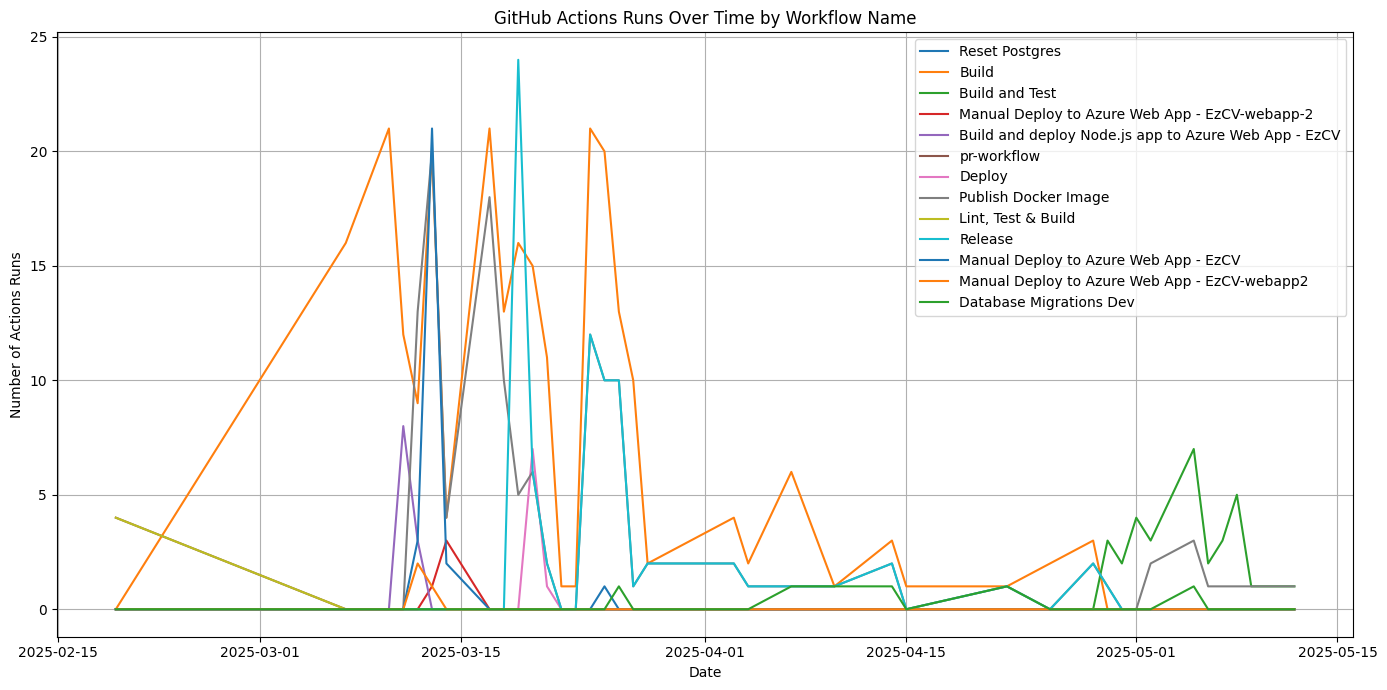

In [55]:
# Get GitHub Actions runs
def get_actions_runs(owner, repo, max_pages=10):
    runs = []
    page = 1
    while page <= max_pages:
        url = f"https://api.github.com/repos/{owner}/{repo}/actions/runs"
        params = {
            "per_page": 100,
            "page": page
        }
        response = requests.get(url, headers=headers, params=params)
        if response.status_code != 200:
            break
        data = response.json()
        if not data.get('workflow_runs'):
            break
        runs.extend(data['workflow_runs'])
        page += 1
    return runs

# Extract (date, workflow name) from the workflow runs
def extract_run_dates_and_names(runs):
    run_dates_names = []
    for run in runs:
        date = run['created_at'][:10]  # YYYY-MM-DD
        name = run['name']  # Workflow name
        run_dates_names.append((date, name))
    return run_dates_names

# Count actions runs per date and workflow name
def count_runs_by_date_and_name(run_dates_names):
    date_name_counts = defaultdict(lambda: Counter())
    for date, name in run_dates_names:
        date_name_counts[date][name] += 1
    return date_name_counts

# Plot actions runs over time grouped by workflow name
def plot_actions_runs(date_name_counts):
    plt.figure(figsize=(14, 7))

    # Loop over each workflow name and plot
    workflow_names = list({name for date in date_name_counts for name in date_name_counts[date]})
    for name in workflow_names:
        dates = sorted(date_name_counts)
        counts = [date_name_counts[date].get(name, 0) for date in dates]
        date_objs = [datetime.strptime(date, "%Y-%m-%d") for date in dates]
        plt.plot(date_objs, counts, label=name)

    plt.title("GitHub Actions Runs Over Time by Workflow Name")
    plt.xlabel("Date")
    plt.ylabel("Number of Actions Runs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    runs = get_actions_runs(OWNER, REPO)
    run_dates_names = extract_run_dates_and_names(runs)
    date_name_counts = count_runs_by_date_and_name(run_dates_names)
    plot_actions_runs(date_name_counts)
